In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd

In [7]:
from datetime import datetime as dt
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b6e283db50>,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08}

In [15]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b6e2849220>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

## Precipitation Analysis

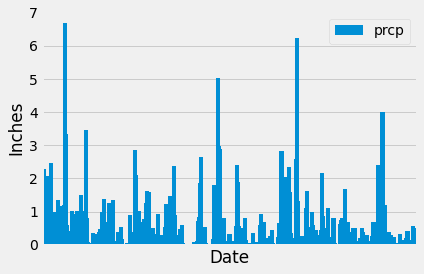

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(sqlalchemy.desc(Measurement.date)).limit(1).all()[0][0]
last_date_obj = dt.strptime(last_date, '%Y-%m-%d')

str_year = str(last_date_obj.year - 1)
str_month = str(last_date_obj.month)
str_day = str(last_date_obj.day)

if last_date_obj.month < 10:
    str_month = '0' + str_month
if last_date_obj.day < 10:
    str_day = '0' + str_day
    
one_year_ago = str_year + '-' + str_month + '-' + str_day

# Perform a query to retrieve the data and precipitation scores
meas_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
meas_df = pd.DataFrame(meas_query)
meas_by_date = meas_df.set_index('date')

# Sort the dataframe by date
meas_sort_by_date = meas_by_date.sort_index().groupby('date').max()

# Use Pandas Plotting with Matplotlib to plot the data
meas_sort_by_date.plot.bar(xlabel = 'Date', ylabel = 'Inches', xticks=(), width=4)

In [14]:
meas_by_date.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [15]:
# Design a query to calculate the total number of stations.
len(session.query(Station.id).distinct().all())

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).order_by(func.count(Measurement.station).desc()).group_by(Measurement.station).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = most_active_stations[0][0]
print(f'Most active station: ', most_active_station)
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()[0][1]
print(f'Lowest temperature recorded by most active station(F): ', lowest_temp)
highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()[0][1]
print(f'Highest temperature recorded by most active station(F): ', highest_temp)
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()[0][1]
print(f'Average temperature recorded by most active station(F): ', avg_temp)

Most active station:  USC00519281
Lowest temperature recorded by most active station(F):  54.0
Highest temperature recorded by most active station(F):  85.0
Average temperature recorded by most active station(F):  71.66378066378067


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


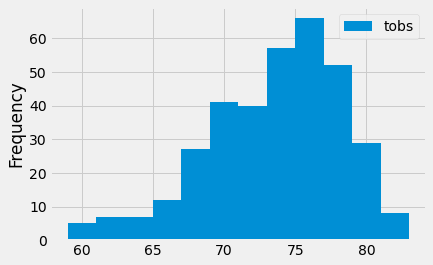

In [18]:
# Choose the station with the highest number of temperature observations.
temp_obs = session.query(Measurement.station, func.count(Measurement.tobs).filter(Measurement.tobs != '')).order_by(func.count(Measurement.tobs).desc()).group_by(Measurement.station)
for row in temp_obs:
    print(row)
high_temp_obs_sta = temp_obs[0][0]
high_temp_obs_sta
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs_sta = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > one_year_ago).filter(Measurement.station == high_temp_obs_sta).all()
temp_obs_sta_df = pd.DataFrame(temp_obs_sta)
hist = temp_obs_sta_df.plot.hist(bins=12)

 # Bonus Challenge Assignment

## Temperature Analysis I

In [28]:
# Identify the average temperature in June and December at all stations across all available years in the dataset
avg_temp_jun = session.query(func.avg(Measurement.tobs)).filter(Measurement.date.like('%-06-%'))[0][0]
avg_temp_dec = session.query(func.avg(Measurement.tobs)).filter(Measurement.date.like('%-12-%'))[0][0]
print(f'Average temperature in June at all stations across all years(F): ', avg_temp_jun)
print(f'Average temperature in December at all stations across all years(F): ', avg_temp_dec)

Average temperature in June at all stations across all years(F):  74.94411764705882
Average temperature in December at all stations across all years(F):  71.04152933421226


In [23]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant
a = session.query(Measurement.tobs).filter(Measurement.date.like('%-06-%')).all()
b = session.query(Measurement.tobs).filter(Measurement.date.like('%-12-%')).all()

# run independent sample T-Test
tStat, pValue = stats.ttest_ind(a, b, equal_var = False)

# print the P-Value and the T-Statistic
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))


P-Value:[4.19352984e-187] T-Statistic:[31.35503692]


* Null Hypothesis: the means of both populations are equal
* Alternate Hypothesis: the means of both populations are not equal

I am using unpaired (independent) t-test because samples from two different populations are being compared: the population of temperatures in June and the population of temperatures in December.
P-Value is very low, so Null Hypothesis is rejected. Poputions do have different average. 

## Temperature Analysis II

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
